### Putting it all together and training the model

The training plot below should trend in this direction

<img src = "../media/reward_iters_3.png" >

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
print ('number of GPUs:', torch.cuda.device_count())

from matplotlib import pyplot as plt 

from minichatgpt.experiments.imdb import config, sent_kwargs
from minichatgpt import Lab, PPOConfig
from minichatgpt.processdata.collators import imdb_dataloader_collator

number of GPUs: 0


In [2]:
# For the sake of the speed of this demonstration, the batch_size is temporarily decreased from 256 to 4
config = PPOConfig(
    model_name="lvwerra/gpt2-imdb", # "distilgpt2", #
    learning_rate= 1.41e-5, # 1e-4,
)

batch_size = 4
config.batch_size = batch_size
config.forward_batch_size = max(batch_size//8,1)

print('config.batch_size', config.batch_size)
print('config.forward_batch_size', config.forward_batch_size)

sent_kwargs = {
    "return_all_scores": True, # need to do this for output[1]["score"] to be the positive score
    #"top_k":None, # dont do this or the index of the score will not always be positive second
    "function_to_apply": "none",
    "batch_size": config.forward_batch_size
}

config.batch_size 4
config.forward_batch_size 1


In [3]:
lab = Lab(config)

dataset = lab.build_dataset(dataset_name="imdb",input_min_text_length=2,input_max_text_length=8)

new_policy, old_policy, tokenizer = lab.init_policies_tokenizer()

lab.set_generation_config(do_sample=True,output_min_length=4,output_max_length=16,pad_token_id=tokenizer.eos_token_id)

ppo_trainer = lab.init_ppo_trainer(
    config, 
    new_policy, 
    old_policy, 
    tokenizer, 
    dataset, 
    dataloader_collator = imdb_dataloader_collator,
)

reward_model = lab.init_reward_model()

print('number of parameters in model', lab.num_params_million(new_policy))
print(new_policy.pretrained_model.device)
print(new_policy.v_head.summary.weight.device)
print(lab.reward_model.model.device)

Found cached dataset imdb (/Users/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Loading cached processed dataset at /Users/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-57d76e4722ace3a5.arrow
Loading cached processed dataset at /Users/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-26d56c39f81904d0.arrow


number of parameters in model 124.440577
cpu
cpu
cpu


In [4]:
rewards_dict = lab.reward_model(
    ['great outstanding an fun movie','boring pretentious script'], 
    **sent_kwargs,
)

rewards_dict

/Users/carson/projects/minichatgpt/venv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'NEGATIVE', 'score': -2.4846701622009277},
  {'label': 'POSITIVE', 'score': 2.7756237983703613}],
 [{'label': 'NEGATIVE', 'score': 2.5873217582702637},
  {'label': 'POSITIVE', 'score': -2.9874801635742188}]]

In [ ]:
config.seed = 0

returns_list = []
rewards_list = []

for batch_step, batch in enumerate(ppo_trainer.dataloader):
    
    queries = batch['input_ids']
    
    #### Get response from gpt2
    responses = []
    for query in queries:
        gen_len = lab.output_length_sampler()
        lab.generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **lab.generation_kwargs)
        responses.append(response.squeeze()[-gen_len:])
        
    batch['response'] = [tokenizer.decode(r.squeeze()) for r in responses]
    
    #### Compute sentiment score
    texts = [q + r for q,r in zip(batch['query'], batch['response'])]
    pipe_outputs = lab.reward_model(texts, **sent_kwargs)
    
    scores = [output[1]["score"] for output in pipe_outputs]
    rewards_list.append(np.mean(scores))
    print('reward', rewards_list[-1])
    
    rewards = [torch.tensor(score) for score in scores]
    
    #### Run PPO step 
    stats = ppo_trainer.step(queries, responses, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)
    
    returns_list.append(stats['ppo/returns/mean'])
    
    #break

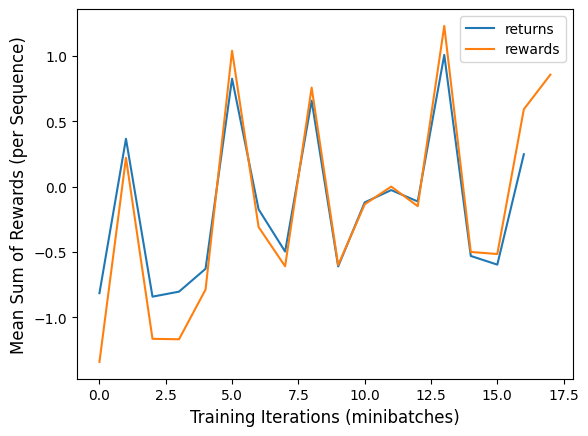

In [6]:
plt.figure()
plt.xlabel('Training Iterations (minibatches)', fontsize=12)
plt.ylabel('Mean Sum of Rewards (per Sequence)', fontsize=12)
plt.plot(returns_list, label='returns')
plt.plot(rewards_list, label='rewards')
plt.legend()
plt.show()

In [7]:
texts[::100]

['The show is about two friends who really need help']

In [8]:
pipe_outputs[::100]

[[{'label': 'NEGATIVE', 'score': -1.4146873950958252},
  {'label': 'POSITIVE', 'score': 1.475325107574463}]]